# Exercise 12.2


In [1]:
import tensorflow as tf

from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.set_random_seed(seed)

## Load data, understand it and prepare the learning process
From the MNIST dataset description, you can see that it contains a set of white handwritten digits centered in a 28x28 image with a black background. 
Well, from my point of view I have just said two problems: 
* the digits are centered 
* all are white with black backgrounds.

A supervised neural network will learn exactly what you give to it: seeing all centered digits, when it will set all its connections it will start to "think" that being centered is a property of the number "six", and so on. The same about the black background: seeing this in all the image the network will learn that it is an important feature of the digits. I don't want this, I want a more flexible network able to discriminate a number not giving importance to its background or to the fact that it is centered or not. 
From my point of view the most beautiful and interesting part of supervised learning is understanding and preparing data (not just building the network). So, let's prepare a dataset that will teach something more interesting to our network than the simple MNIST dataset.

In [2]:
from tensorflow.keras.datasets import mnist
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In the next lines of code I will take care of the background. The trick is to invert some of the image, for instance 30% of the dataset will become with black digit and white background. 

In [3]:
X_train_inverted=np.invert(X_train[0: int(X_train.shape[0]/3)]) #inverting bits!
X_train_not_inverted=X_train[int(X_train.shape[0]/3) :]
X_train = np.concatenate((X_train_inverted, X_train_not_inverted)) #merging again the inverted and normal images

I will not transform the test set: this is used just for testing, not for training, so it will not affect the result of the learning process.

## Preprocessing
The first step is just creating the category to learn and reshape the image for keras.

In [4]:
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)


# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Now we need to do two important things:
* Normalize the data
* Create some hints that can suggest  that centering is not an important feature.
All neural network routines expect normalized data. In particular image processing expects numbers between [0,1]. 
For the preprocessing I will use `ImageDataGenerator`, an utils from keras designed to create variability in the image: this process is called "data augmentation". I will instruct this class to rotate, rescale and shift (both vertically and horizonatlly) the images: after that some image will be randomly displaced in the frame (the rescaling will apply to all).

In exercise 12.3 you can see the difference of doing this data augmentation and not to do it. 

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.18,
        height_shift_range=0.1,
) 

#on test we only need to rescale
test_datagen = ImageDataGenerator(rescale=1./255) 

train_datagen.fit(X_train)
test_datagen.fit(X_test)

Let's see the effect of all the transformations on some images:

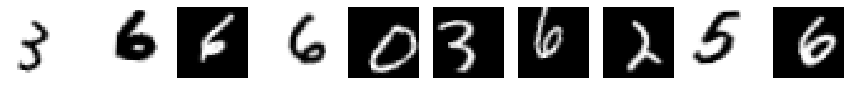

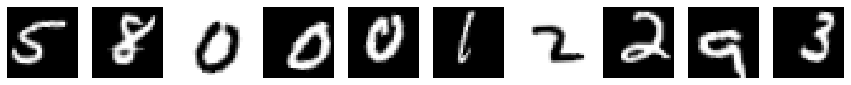

In [6]:
batches = train_datagen.flow(X_train, Y_train)
x, y = batches.next()
plt.figure(figsize=(15,15))
for i in range(10):
    image = x[i]*255 #unscale
    
    ax = plt.subplot(2, 10, i + 1)  
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off') 
plt.show()
plt.figure(figsize=(15,15))
for i in range(10,20):
    image = x[i]*255 #unscale
    
    ax = plt.subplot(2, 10, i + 1)  
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off') 
plt.show()

## Building the Convolutional Neural Network 

Now it's time to create the model. I will instantiate two convolutional layers, two fully connected hidden layers (actually one may be enough..) and one output layer.

As optimizer I will use `adam` that is one of the best for convolutional networks.
The most important thing here is not to forget to put some nonlinearity in the convolutional layer (a relu is fine), without it having more than one convolutional layer is completely useless: it can be shown that a cascade of linear layer is equal to having a single layer of the lowest dimensionality (with everything linear we are just multiplying matrices, so the product is a single matrix).

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Dropout
def create_CNN():
    # instantiate model
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #another convolutional layer: a good "rule" is to double the number of filters
    model.add(Conv2D(32, kernel_size=(5, 5),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
  
    
    #some dropout to avoid overfitting
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(units=120, activation="relu",))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=80, activation="relu",))
    model.add(Dropout(0.2))
    #output layer
    model.add(Dense(units=10, activation="softmax"))
        
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Fit the model. I have a GPU on my pc, may be very long on a laptop CPU...

In [8]:
# training parameters
batch_size = 32
epochs = 4

#those will be used in the NN
training_set=train_datagen.flow(X_train, Y_train, batch_size=batch_size)
test_set=test_datagen.flow(X_test, Y_test, batch_size=batch_size)


# create the deep conv net
model_CNN=create_CNN()
saved=False
save_model_path="model/conv_model"

if(saved==True):
    model_old = tf.keras.models.load_model(filepath=save_model_path)
else:
# train CNN

    history= model_CNN.fit_generator(training_set,
                                 epochs=epochs,
                                 steps_per_epoch=len(X_train) /batch_size,
                                 verbose=1,
                                 validation_data=test_set,
                                 validation_steps=len(X_test)/batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6043 - acc: 0.8012 - val_loss: 0.0665 - val_acc: 0.9782
Epoch 2/4
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2228 - acc: 0.9319 - val_loss: 0.0418 - val_acc: 0.9863
Epoch 3/4
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1797 - acc: 0.9447 - val_loss: 0.0337 - val_acc: 0.9885
Epoch 4/4
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1538 - acc: 0.9530 - val_loss: 0.0340 - val_acc: 0.9882


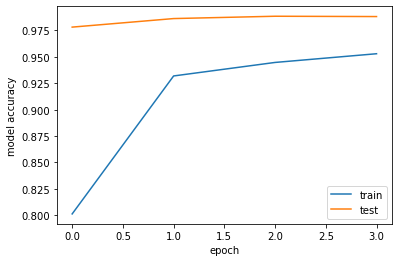

In [9]:
# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Evaluation


I will now analyze the scoring on both the "normal" test set and on the "inverted" image test set:

In [10]:
# evaliate model
score = model_CNN.evaluate(test_set, verbose=1, batch_size=batch_size)

X_test_inverted=np.invert(X_test)
test_set_inverted=test_datagen.flow(X_test_inverted, Y_test, batch_size=batch_size)

score_inverted = model_CNN.evaluate(test_set_inverted)

#score_inverted = model_CNN.evaluate(X_test_inverted, verbose=1, batch_size=batch_size)

# print performance
print()
print("Normal test set")
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()
print("Inverted test set")
print('Test loss:', score_inverted[0])
print('Test accuracy:', score_inverted[1])


313/313 [==============================] - 0s 1ms/step - loss: 0.0497 - acc: 0.9841

Normal test set
Test loss: 0.0340406845940036
Test accuracy: 0.9882

Inverted test set
Test loss: 0.04971291586706867
Test accuracy: 0.9841


Let's see some example on the "normal" test set:

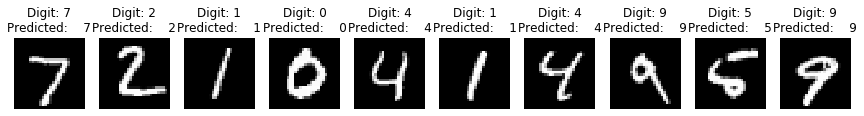

In [11]:
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Now let's analyze the same image on the "inverted" test set:

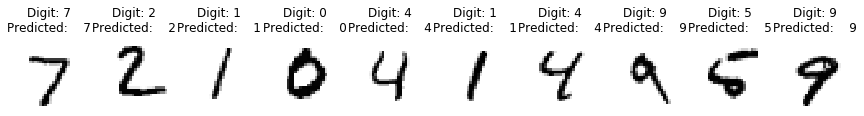

In [12]:
predictions_inverted = model_CNN.predict(X_test_inverted)


X_test_inverted = X_test_inverted.reshape(X_test_inverted.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test_inverted[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions_inverted[i])))    
    plt.axis('off') 
plt.show()

The network performed almost perfectly both on normal digits and inverted one. I find it fascinating how it was enough to invert the color of just 30% of the images to teach the network that background and colors aren't an import feature of the object "digits".

In [13]:
#if needed save
save_model_path="model/conv_model_inverted"
if(saved==False):
    model_CNN.save(filepath=save_model_path, include_optimizer=True)

In [14]:
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               61560     
__________